# Llama from scratch (or how to implement a paper without crying)

## Setting up our dataset

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd

In [22]:
lines = open('./data/Shakespeare.txt', 'r').read()

vocab = sorted(list(set(lines)))
itos = {i:ch for i, ch in enumerate(vocab)}
stoi = {ch:i for i, ch in enumerate(vocab)}

print(lines[:30])

First Citizen:
Before we proce


In [23]:
# simple tokenization by characters
def encode(s):
    return [stoi[ch] for ch in s]

def decode(l):
    return ''.join([itos[i] for i in l])

print('vocab size:', len(vocab))
decode(encode("hello"))

vocab size: 65


'hello'

In [24]:
MASTER_CONFIG = {
    "vocab_size": len(vocab),
}

In [25]:
dataset = torch.tensor(encode(lines), dtype=torch.int8)
dataset.shape

torch.Size([1115394])

In [26]:
def get_batches(data, split, batch_size, context_window, config=MASTER_CONFIG):
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]

    if split == 'train':
        batch_data = train
    elif split == 'test':
        batch_data = test
    else:
        batch_data = val

    # pick random starting points
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()
    return x, y

MASTER_CONFIG.update({
    'batch_size': 8,
    'context_window': 16
})

xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

[(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]

[("engeance for't\nN", "ngeance for't\nNo"),
 (" that name's woe", "that name's woe."),
 ('le.\n\nAll:\nWe kno', 'e.\n\nAll:\nWe know'),
 ('ng now provided\n', 'g now provided\nA'),
 ('nour I for aye a', 'our I for aye al'),
 ('wer nay, and tak', 'er nay, and take'),
 ('.\n\nVIRGILIA:\nBut', '\n\nVIRGILIA:\nBut '),
 ('NBURY:\nI cry you', 'BURY:\nI cry you ')]

## Evaluation

In [27]:
@torch.no_grad()  # don't compute gradients for this function
def evaluate_loss(model, config=MASTER_CONFIG):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = []
        for _ in range(10):
            xb, yb = get_batches(dataset, split, config['batch_size'], config['context_window'])
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    model.train()
    return out

## Setting up a working base model

In [45]:
class SimpleBrokenModel(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )
        
        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        a = self.linear(x)
        logits = F.softmax(a, dim=-1)

        # print(logits.view(-1, self.config['vocab_size']).shape)
        # print(targets.view(-1).shape)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

MASTER_CONFIG.update({
    'd_model': 128,
})
model = SimpleBrokenModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)

model params: 33217


model params: 33217
Epoch 0 | val loss 4.174 | Time 0.004 | ETA in seconds 0.366
Epoch 10 | val loss 4.156 | Time 0.017 | ETA in seconds 1.696
Epoch 20 | val loss 4.105 | Time 0.018 | ETA in seconds 1.758
Epoch 30 | val loss 4.051 | Time 0.017 | ETA in seconds 1.658
Epoch 40 | val loss 4.003 | Time 0.016 | ETA in seconds 1.491
Epoch 50 | val loss 3.972 | Time 0.017 | ETA in seconds 1.596
Epoch 60 | val loss 3.962 | Time 0.017 | ETA in seconds 1.617
Epoch 70 | val loss 3.958 | Time 0.020 | ETA in seconds 1.873
Epoch 80 | val loss 3.968 | Time 0.017 | ETA in seconds 1.532
Epoch 90 | val loss 3.949 | Time 0.016 | ETA in seconds 1.462
Epoch 100 | val loss 3.953 | Time 0.016 | ETA in seconds 1.422
Epoch 110 | val loss 3.949 | Time 0.015 | ETA in seconds 1.360
Epoch 120 | val loss 3.955 | Time 0.021 | ETA in seconds 1.855
Epoch 130 | val loss 3.947 | Time 0.012 | ETA in seconds 1.085
Epoch 140 | val loss 3.952 | Time 0.012 | ETA in seconds 1.062
Epoch 150 | val loss 3.958 | Time 0.012 | ETA 

<Axes: >

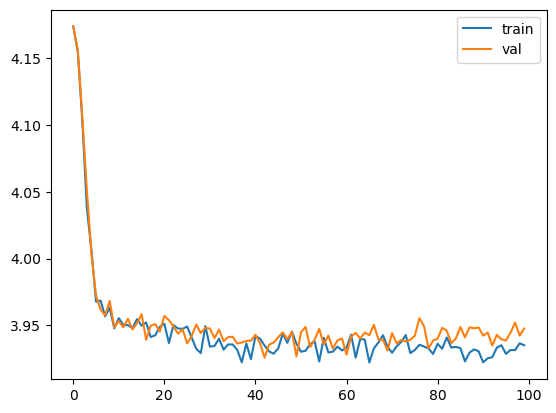

In [52]:
MASTER_CONFIG.update({
    'epochs': 1000,
    'log_interval': 10,
    'batch_size': 32,
})
model = SimpleBrokenModel(MASTER_CONFIG)

optimizer = torch.optim.Adam(
    model.parameters(), 
)

def train(model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=False):
    losses = []
    start_time = time.time()
    for epoch in range(config['epochs']):
        optimizer.zero_grad()

        xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])
        logits, loss = model(xs, targets=ys)
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        if epoch % config['log_interval'] == 0:
            batch_time = time.time() - start_time
            x = evaluate_loss(model)
            losses += [x]
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")
            start_time = time.time()

            if scheduler:
                print("lr: ", scheduler.get_lr())

    # print(pd.DataFrame(losses))
    print("validation loss: ", losses[-1]['val'])
    return pd.DataFrame(losses).plot()

train(model, optimizer, print_logs=True)

In [49]:
losses

NameError: name 'losses' is not defined